# RNA-Seq Analysis

## Transcriptional Predictors of Carriage

__Studies__: Mucosal | LAIV1 | LAIV2 | AGES  
__Timepoint(s)__: baseline  
__Method__: machine learning (DaMiRSeq)

## Carriage-relate Transcriptional Differences at baseline

__Studies__: Mucosal | LAIV1 | LAIV2 | AGES  
__Timepoint(s)__: baseline  
__Method__: Differential Expression Analysis (DESeq2)

## Carriage-related Transcriptional Pertubations ($Day_x vs. baseline$)

__Studies__: Mucosal | LAIV2 | AGES  
__Timepoint(s)__: baseline, Day 2 and Day 9  
__Method__: Differential Expression Analysis (DESeq2)

In [32]:
rm(list = ls())
pkgs <- c('tidyverse','data.table','MultiAssayExperiment','DESeq2',"BiocParallel")
suppressPackageStartupMessages(sapply(pkgs,require,character.only = T))
register(MulticoreParam(3))

tidyverse           data.table MultiAssayExperiment 
                TRUE                 TRUE                 TRUE 
              DESeq2         BiocParallel 
                TRUE                 TRUE

In [33]:
create_tempData <- function(data.sub) {
    if(!dir.exists) dir.create('temp')
    count = cbind(gene_id = rownames(data.sub),assay(data.sub))
    pheno = cbind(sample_id = colnames(data.sub), as.data.frame(colData(data.sub)))
    write.table(count, 'temp/counts.csv', sep = '\t', row.names = F)
    write.table(pheno, 'temp/pheno.csv', sep = '\t', row.names = F)
}

In [34]:
meta <- fread('data/raw_data/MIXED/EHPC_Density_Data_12MARCH2020.tsv') %>% data.frame(row.names = 'sample_id')
meta = meta %>% filter(!duplicated(volunteer_id)) %>% mutate(study = toupper(study))
head(meta)

,volunteer_id,study,group,sex,age,vaccine,vaccine_date,virus,virus_species,carriage,timepoint_naturalcarriage,serotype_naturalcarriage,date_inoculated,inoculation_dose,inoculation_serotype,timepoint,density
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
152/01_D2,152/01,GATES_DOSERANGING,NA,F,38,NA,NA,NA,NA,NEG,NA,NA,14-11-2011,9833,6B,D2,NA
154/02_D2,154/02,GATES_DOSERANGING,NA,F,23,NA,NA,NA,NA,NEG,NA,NA,14-11-2011,11166,6B,D2,NA
183/164_D2,183/164,GATES_DOSERANGING,NA,F,24,NA,NA,NEG,Virus_Neg,NEG,NA,NA,18-06-2012,313333,6B,D2,NA
187/03_D2,187/03,GATES_DOSERANGING,NA,F,20,NA,NA,NA,NA,POS,NA,NA,14-11-2011,11166,6B,D2,5.1343364
188/04_D2,188/04,GATES_DOSERANGING,NA,F,21,NA,NA,NEG,Virus_Neg,POS,NA,NA,05-12-2011,54833,6B,D2,0.9063350
189/05_D2,189/05,GATES_DOSERANGING,NA,F,25,NA,NA,NA,NA,POS,NA,NA,29-11-2011,49500,6B,D2,0.2966652


### Mucosal

In [5]:
data <- readRDS('data/tidy_data/MUCOSAL_rnaseq.rds')

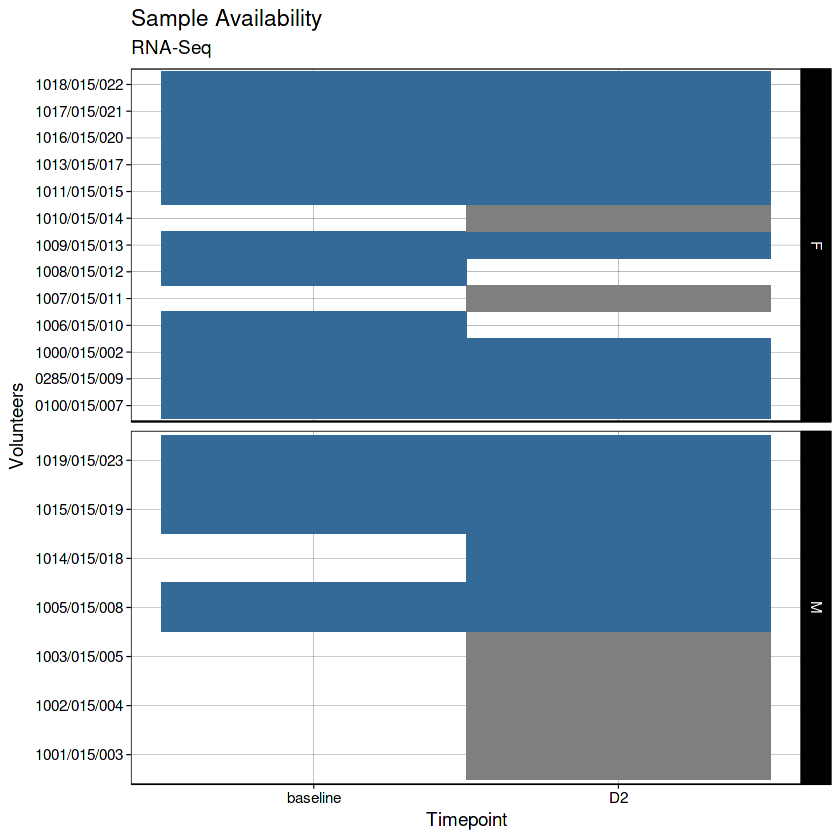

In [6]:
temp = merge(colData(data), meta, by = 'volunteer_id', all = T) %>% as.data.frame %>%
    mutate(sample_availability = ifelse(is.na(timepoint.x),NA,1))
ggplot(temp, aes(ifelse(is.na(timepoint.x),'D2',timepoint.x), volunteer_id, fill = sample_availability)) +
    geom_tile(show.legend = F) + facet_grid(sex~., scales = 'free') + theme_linedraw() +
    labs(title = "Sample Availability", subtitle = "RNA-Seq", x = 'Timepoint', y = 'Volunteers')

In [7]:
colData(data) = colData(data) %>% as.data.frame %>% rownames_to_column('sample_id_temp') %>% 
    merge(., meta, by = 'volunteer_id', all.x = T) %>% column_to_rownames('sample_id_temp') %>% DataFrame

#### Women

Carriage+

In [35]:
# data.sub = data[,which(data$sex == 'F' & data$carriage == 'POS')]
# # create_tempData(data.sub)

# min_numSample_class = min(table(data.sub$sex, data.sub$carriage, data.sub$timepoint.x))
# # rowSums(assay(data.sub))
# dds <- DESeqDataSetFromMatrix(countData = as.matrix(assay(data.sub)),colData = colData(data.sub), design = ~ volunteer_id + timepoint.x)
# dds <- DESeq(dds, parallel = T)
# # resultsNames(dds)
# res = results(dds, name = 'timepoint.x_D2_vs_baseline', parallel = T)
# res.df = as.data.frame(res)

Carriage -

#### Men

Carriage +

Carriage -

### LAIV2

### AGES

In [89]:
studies <- c('MUCOSAL', 'LAIV2', 'AGES')

comparisons = expand.grid(study  = studies,
                          carriage = c('POS','NEG'),
                          sex = c('M','F')) %>% mutate(Up = NA, Down = NA)
comparisons = comparisons[-1,]

rnaseq_fnames <- list.files('data/tidy_data/', pattern = '_rnaseq',full.names = T)
rnaseq_fnames = grep(paste0(studies, collapse = '|'),rnaseq_fnames,value = T)

In [90]:
rnaseq_fnames

[1] "data/tidy_data//AGES_rnaseq.rds"    "data/tidy_data//LAIV2_rnaseq.rds"  
[3] "data/tidy_data//MUCOSAL_rnaseq.rds"

In [91]:
rnaseq.data <- lapply(rnaseq_fnames, readRDS) %>% setNames(gsub('_.*','',basename(rnaseq_fnames)))

In [92]:
for(study.id in studies) { # study.id = studies[1]
    pheno = meta %>% filter(study == study.id) %>% select(-timepoint)
    colData(rnaseq.data[[study.id]]) = colData(rnaseq.data[[study.id]]) %>% as.data.frame %>% 
    rownames_to_column('sample_id_temp') %>% merge(., pheno, by = 'volunteer_id', all.x = T) %>%
    column_to_rownames('sample_id_temp') %>% DataFrame
}

In [93]:
# lapply(rnaseq.data, colData)

In [94]:
subset_rnaseq <- function(data, sex, carriage) data[,which(data$sex == sex & data$carriage == carriage)]

In [97]:
rnaseq.subsets  = apply(comparisons, 1, function(df) { # df = comparisons[1,];df
    study = df[1]; carriage = df[2]; sex = df[3]
    message(paste0('Study: ',study, '\t|\tCarriage: ',carriage,'\t|\tSex: ',sex))
    return(subset_rnaseq(rnaseq.data[[study]], sex, carriage))
})

Study: LAIV2	|	Carriage: POS	|	Sex: M

Study: AGES	|	Carriage: POS	|	Sex: M

Study: MUCOSAL	|	Carriage: NEG	|	Sex: M

Study: LAIV2	|	Carriage: NEG	|	Sex: M

Study: AGES	|	Carriage: NEG	|	Sex: M

Study: MUCOSAL	|	Carriage: POS	|	Sex: F

Study: LAIV2	|	Carriage: POS	|	Sex: F

Study: AGES	|	Carriage: POS	|	Sex: F

Study: MUCOSAL	|	Carriage: NEG	|	Sex: F

Study: LAIV2	|	Carriage: NEG	|	Sex: F

Study: AGES	|	Carriage: NEG	|	Sex: F



In [ ]:
rnaseq.subsets

## Time-wise Transcriptional Profiles related to Carriage Development
Look: https://academic.oup.com/bioinformatics/article/21/suppl_1/i159/203147

In [86]:
temp = rnaseq.data$MUCOSAL

In [87]:
table(temp$sex, temp$carriage)

   
    NEG POS
  F  11   9
  M   6   1